# Reproducing thesis

### Preparing the ERA5 data
First we load in the ERA5 data using `xarray`

In [1]:
region_na = {
    "latitude": slice(15, 60),
    "longitude": slice(220, 305),
}

In [2]:
import xarray as xr
from pathlib import Path
import numpy as np


files = list(Path("/home/bart/Data/daily_era5").glob("*.nc"))[:1]
ds = xr.open_mfdataset(files).isel(time=slice(0,4)).load()
ds = ds.sortby(["longitude","latitude"])

The resolution is 0.25 degrees, so a coarsen operation could result in a 1-degree resolution dataset.

In [25]:
ds["longitude"].to_numpy()[:5]


array([0.  , 0.25, 0.5 , 0.75, 1.  ], dtype=float32)

However, when we look at the results, the grid is not aligned on even numbers:

In [26]:
ds_coarsened = ds.coarsen(longitude=4, latitude=4, boundary="pad").mean()
ds_coarsened["longitude"].to_numpy()[:5]

array([0.375, 1.375, 2.375, 3.375, 4.375], dtype=float32)

To be able to align on even numbers, the windows need to be of length 5, and be overlapping.

E.g.: `[0.5 , 0.75, 1., 1.25, 1.5]` will have a mean of `1.`

Additionally, the next windows will be  `[1.5 , 1.75, 2., 2.25, 2.5]`, and overlap with the first window.

We can perform this operation with a rolling window, and then extract the coordinates we are interested in:


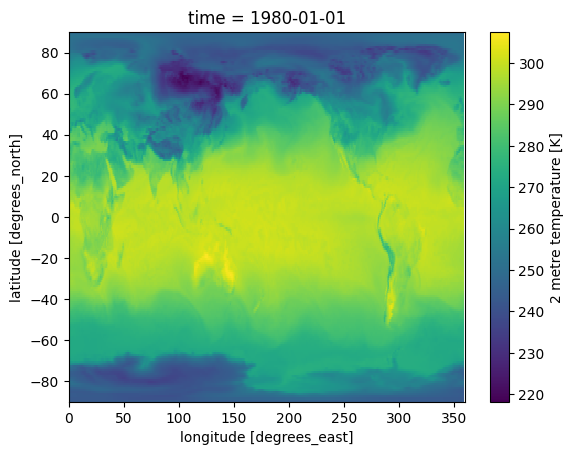

In [4]:
dsr = ds.rolling(latitude=5, center=True).mean()
dsr = dsr.rolling(longitude=5, center=True).mean()

lats = np.arange(-89.5, 90, step=1)
lons = np.arange(0.5, 360, step=1)

era5_1deg = dsr.sel(latitude=lats, longitude=lons)

era5_1deg["t2m"].isel(time=0).plot()

### Carbontracker
North American Temperate Region has a region ID of `2.`

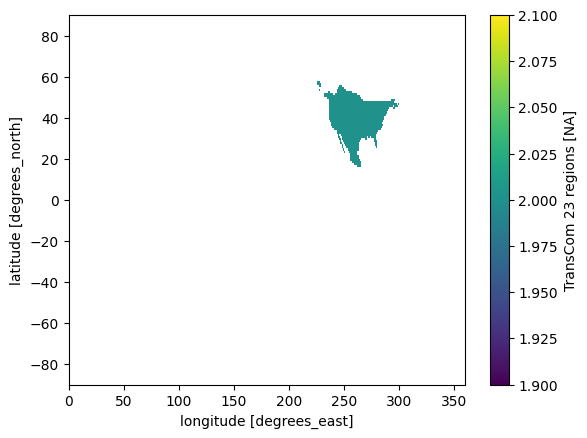

In [5]:
ds_regions = xr.open_dataset("/home/bart/Data/EXCITED/regions.nc")
ds_regions["longitude"] = ds_regions["longitude"].where(ds_regions["longitude"]>0, ds_regions["longitude"]+360)
ds_regions = ds_regions.sortby(["latitude", "longitude"])
ds_regions["transcom_regions"].where(ds_regions["transcom_regions"]==2).plot()

Get the ERA5 data for only the NA region:

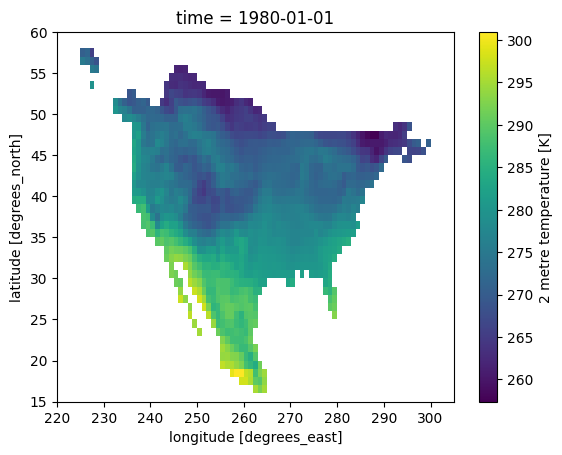

In [6]:
dsm = xr.merge([
    era5_1deg,
    ds_regions["transcom_regions"]
])
dsm = dsm.sel(region_na)
dsm["t2m"].where(dsm["transcom_regions"]==2).isel(time=0).plot()

Let's load the carbontracker data:

In [7]:
ds_cb = xr.open_dataset("/home/bart/Data/EXCITED/CT2022.flux1x1-monthly.nc")
ds_cb["longitude"] = ds_cb["longitude"].where(ds_cb["longitude"]>0, ds_cb["longitude"]+360)
ds_cb = ds_cb.sortby(["latitude", "longitude"])

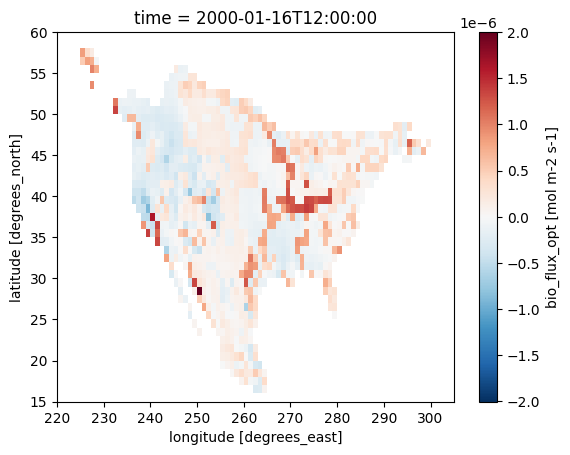

In [8]:
ds_cb["bio_flux_opt"].sel(region_na).where(dsm["transcom_regions"]==2).isel(time=0).plot()